# Data analysis - Comparing absolute and incremental encoders

The following script can be used to compare any other Galil/Beckhoff files imported in the same .csv configurations.

In [2]:
import os, matplotlib.pyplot as plt, numpy as np, pandas as pd
from scipy.fft import rfft, rfftfreq

global path_beckhoff, path_galil

#Input path to files
path_beckhoff='./beckhoff-data'
path_galil='./galil-data'

#get list of all available files in alphabetical order
files_beckhoff = sorted(f for f in os.listdir(path_beckhoff) if os.path.isfile(os.path.join(path_beckhoff,f)))
files_galil = sorted(f for f in os.listdir(path_galil) if os.path.isfile(os.path.join(path_galil,f)))

if files_beckhoff != files_galil:
    print("*"*100)
    print("*"*44, "WARNING!!!","*"*44)
    print("*"*100)
    print(f'Every setup to be compared must have a pair of files named the same. Check {(set(files_beckhoff) - set(files_galil))} for a pair')

### General Preprocessing Routines - Cleaning and filtering data

Bekchoff files comes with some info headers. It's convenient to remove them to get cleaner data.

The following script saves the edited files in a new folder:

In [3]:
for file in files_beckhoff:
    b_file_source = f'{path_beckhoff}/{file}'
    
    if not os.path.isdir(f'{path_beckhoff}/edited'):
        os.makedirs(f'{path_beckhoff}/edited/')
    b_file_dest   = f'{path_beckhoff}/edited/{file}'
    #create new file without beckhoff file headers
    with open(b_file_source, 'r') as file:
        lines = file.readlines()
    with open(b_file_dest, 'w') as file:
        for index, line in enumerate(lines):
            if index == 6 or index>22:
                file.write(line)
#Update paths
path_beckhoff=f'{path_beckhoff}/edited'                
files_beckhoff = sorted(f for f in os.listdir(path_beckhoff) if os.path.isfile(os.path.join(path_beckhoff,f)))

As seen in the next figure, raw collected data points are displaced in time and unaligned:

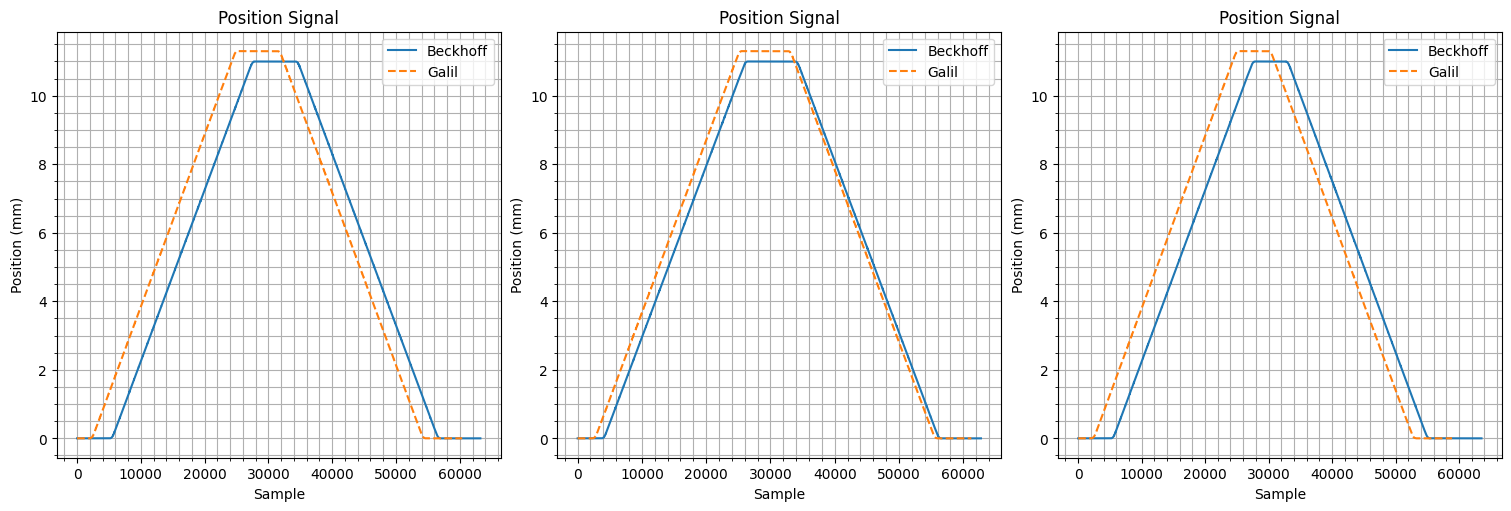

In [4]:
plt.figure(figsize=(15, 5), constrained_layout=True)

for i in range(3): #picking only the first three files as example
    raw_g_file_source = f'{path_galil}/{files_galil[i]}' 
    raw_b_file_source = f'{path_beckhoff}/{files_beckhoff[i]}' 
    raw_g_data = pd.read_csv(raw_g_file_source, sep=' ', header=None)
    raw_b_data = pd.read_csv(raw_b_file_source, sep='\t', decimal=',')
   
    plt.subplot(1, 3, i+1)
    plt.plot(raw_b_data.index, raw_b_data['ActPos'], label='Beckhoff')
    plt.plot(raw_g_data.index, raw_g_data[5], label='Galil', linestyle='dashed')
    plt.xlabel('Sample')
    plt.ylabel('Position (mm)')
    plt.title('Position Signal')
    plt.legend()
    plt.minorticks_on()
    plt.grid(True, axis='both', which='both')

    
plt.show()

In the following sections some strategies were adopted to minimize those problems, such as:

**1. Setting "movement surely started" and "movement surely ended" points as position references;**
- Defining some position (for example 0.1mm) where we can be sure that Kyma could not be unless movement was starting or ending.

**2. Get a fixed amount of points before and after position reference set in the previous step;**
- Considering sampling rates are close enough, another aligning strategy was reshaping both data to N points (2000 for example) before and after a specific position.

**3. Converting both timestamps to seconds;**
- Bekchoff timestamp is in TwinCAT time format (number of 100 ns steps since January 1, 1601).
- Galil timestamps are set in yyyy-mm-dd hh:mm:ss
    
**4. Applying reescaling factors.**
- Bekchoff's equivalence between encoder pulses and milimmeters must be corrected before analyzing. 

#### Galil preprocessing

In [5]:
def get_g_data(filename):
    g_file_source = f'{path_galil}/{filename}'
    g_data = pd.read_csv(g_file_source, sep=' ', header=None)
  
    g_data.drop(g_data.columns[[0,1,2,3,6,7]], axis=1, inplace=True) #remove csv created columns or unused ones
    g_data.columns = ['Elapsed time (s)', 'PVvalue']
    
    """     Convert each timestamp to seconds:
            1 - split hh:mm:ss and invert it (ss:mm:hh)
            2 - index each timestamp frame [0,1,2]
            3 - Multiply each timeframe by 60^index, where index=[0,1,2]
            4 - Save conversions to a list and replace the original column
    """
    g_delta_s = []
    for timestamp in g_data['Elapsed time (s)']:
        secs = 0
        for i, timeframe in enumerate(reversed(timestamp.split(':'))):
            secs = secs + float(timeframe)*60**i
        g_delta_s.append(secs)
    g_data['Elapsed time (s)'] = g_delta_s
    
    g_timediff = g_data['Elapsed time (s)'].diff() #get deviation from one timestamp to the next
    # todrop = []
    # for index, timediff in enumerate(g_timediff.values): #replace samples within less than 0.5ms by the mean between them - ensure 1ms sampling frequency
    #     if timediff < 0.0005:
    #         g_data['PVvalue'].iloc[index-1] = (g_data['PVvalue'].iloc[index-1] + g_data['PVvalue'].iloc[index])/2
    #         todrop.append(index)
    # g_data.drop(todrop,inplace=True)
    
    start_point = g_data.loc[g_data['PVvalue']>=0.01].index[0]                                                       #ensure movement started (pos>0.01) and save index
    end_point = g_data.loc[(g_data['PVvalue']<=0.01) & (g_data.index > start_point)].index[0]                        #ensure movement is ending (pos<0.01) and save index
    g_data = g_data[(g_data.index>(start_point - 2000)) & (g_data.index<(end_point + 2000))].reset_index(drop=True)  #keep only 2000 samples (2s) before and after movement starting
    
    g_data['Elapsed time (s)'] = g_timediff.cumsum().fillna(0)                                                       #set timestamps as cumulative sum starting from zero 
    return g_data 

#### Beckhoff preprocessing

In [6]:
def get_b_data(filename):
    b_file_source = f'{path_beckhoff}/{filename}'
    b_data = pd.read_csv(b_file_source, sep='\t', decimal=',')
    scalefactor = 0.5/0.48655
    b_data['ActVelo'] = b_data['ActVelo']*scalefactor                                                            #correct scale factor
    b_data['ActPos'] = b_data['ActPos']*scalefactor                                                             
    b_data['ActAcc'] = b_data['ActAcc']*scalefactor  

    #Cleaning data
    b_data.drop(b_data.columns[[2,4]],axis=1, inplace=True)                                                     #drop repeated columns
    b_data = b_data.iloc[:-1]                                                                                   #remove last line (EOF)
    b_data = b_data.apply(pd.to_numeric)                                                                        #set everything as numbers
    start_point = b_data.loc[b_data['ActPos']>=0.01].index[0]                                                   #ensure movement started (pos>0.01) and save index
    end_point = b_data.loc[(b_data['ActPos']<=0.01) & (b_data.index>start_point)].index[0]                      #ensure movement is ending (pos<0.01) and save index 
    b_data = b_data[(b_data.index>(start_point-2000)) & (b_data.index<(end_point+2000))].reset_index(drop=True) #keep only 2000 samples (2s) before and after movement starting
    b_delta_time = b_data['Name'].diff()                                                                        #get deviation from one timestamp to the next
    b_delta_time = b_delta_time*(10**-7)                                                                        #from documentation, TwinCAT time is in steps of 100ns (10^-7 seconds)
    b_data['Name'] = b_delta_time.cumsum().fillna(0)                                                            #set timestamps as cumulative sum starting from zero
    b_data.rename(columns={'Name':'Elapsed time (s)'}, inplace=True);                                           #rename treated column
                                                           
    return b_data

In order to validate the data processing, the same three graphs as before can be plotted.

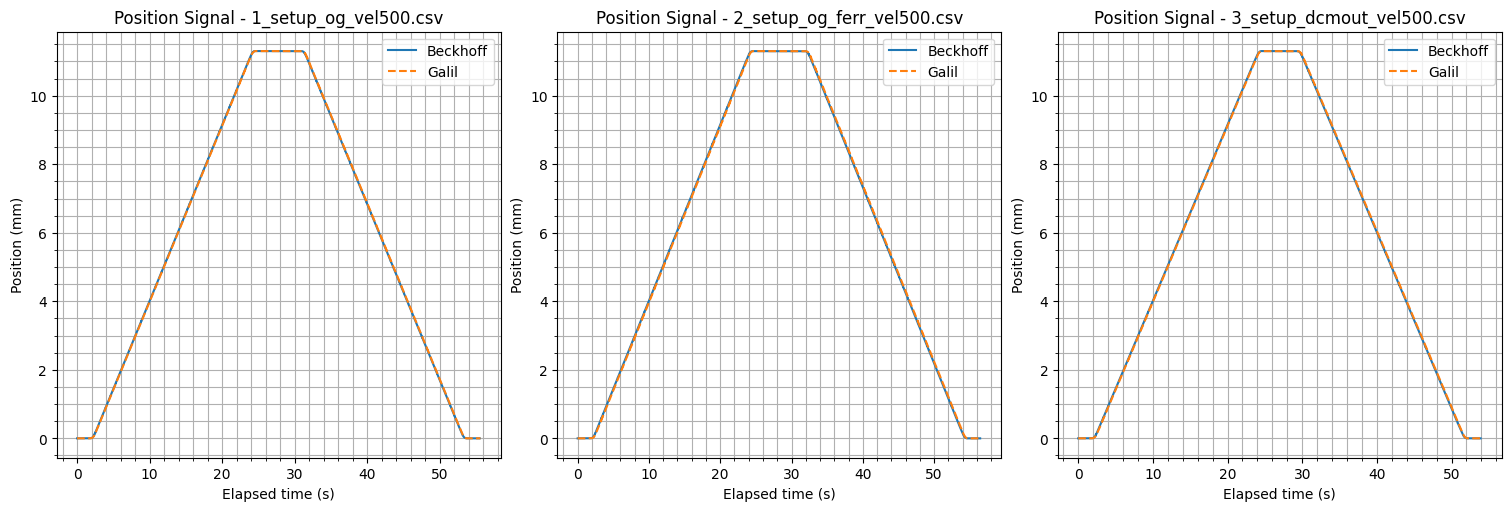

In [7]:
plt.figure(figsize=(15, 5), constrained_layout=True)
for i in range(3): #picking only the first three files as example
    cleaned_b_data = get_b_data(files_beckhoff[i])
    cleaned_g_data = get_g_data(files_galil[i])
   
    plt.subplot(1,3,i+1)
    plt.plot(cleaned_b_data['Elapsed time (s)'], cleaned_b_data['ActPos'], label='Beckhoff')
    plt.plot(cleaned_g_data['Elapsed time (s)'], cleaned_g_data['PVvalue'], label='Galil', linestyle='dashed')
    plt.xlabel('Elapsed time (s)')
    plt.ylabel('Position (mm)')
    plt.title(f'Position Signal - {files_beckhoff[i]}')
    plt.legend()
    plt.minorticks_on()
    plt.grid(True, axis='both', which='both')

plt.show()

## Data Analysis

The following script can be run to generate informative plots about all files, including position signals, encoder differences and respective FFT analysis.

One might want to analyze and compare movement in small portions. The number of parts to divide movement can be set below:

In [8]:
nparts = 1 #number of sections each movement is going to be divided to further analysis

* **Note**: *For script documentation purposes, nparts was set to 3 and the following loop iterates only over the first pair of files and plot 4 graphs (position, position difference and ffts) for each.*

    *To iterate over all files and divide movement in X parts, set nparts=X, uncomment next block's first line and comment the seconde one.*

Full movement analysis - 1_setup_og_vel500.csv


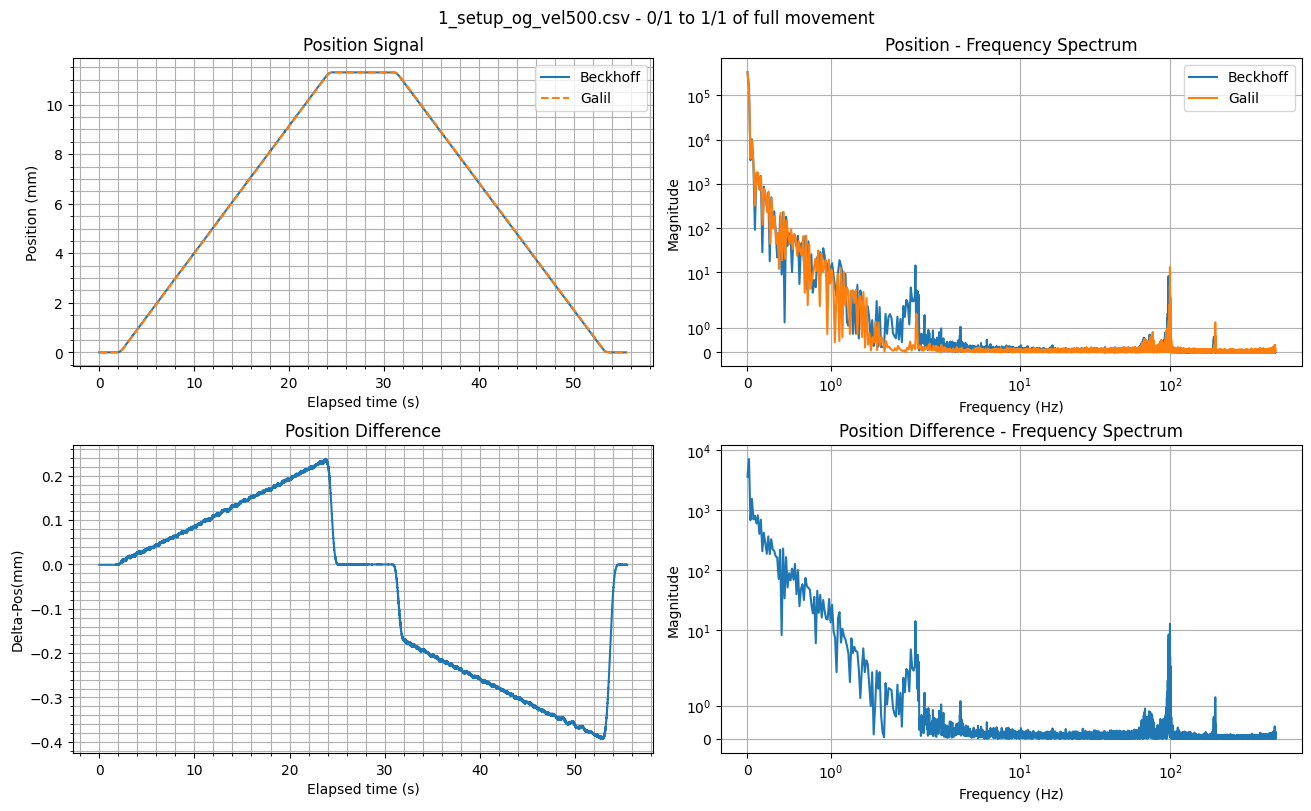

In [9]:
# for i in range(len(files_beckhoff)): #amount of files is expected to be the same for both, thus getting one of them must be ok
for i in range(1): 
    filename = files_beckhoff[i] #name of file pairs is expected to be the same, thus getting one of them must be ok
    print(f'Full movement analysis - {filename}')
    b_raw_data = get_b_data(filename)
    g_raw_data = get_g_data(filename)
    
    for part in range(nparts):
        diff = pd.DataFrame()   
        b_data = b_raw_data.iloc[int(len(b_raw_data)*(part)/nparts):int(len(b_raw_data)*(part+1)/nparts)].reset_index()
        g_data = g_raw_data.iloc[int(len(g_raw_data)*(part)/nparts):int(len(g_raw_data)*(part+1)/nparts)].reset_index()
        
        b_time = b_data['Elapsed time (s)']
        b_velo = b_data['ActVelo']
        b_acc = b_data['ActAcc']
        b_pos = b_data['ActPos']
        g_time = g_data['Elapsed time (s)']
        g_pos = g_data['PVvalue']
        diff['Pos. Difference'] = (b_pos - g_pos).fillna(method="ffill")
        diff['Elapsed Time (s)'] = b_time #chose beckhoff's time as difference timestamp
        pos_difference = diff['Pos. Difference']

        # positions fft
        b_nsamples = len(b_pos)
        b_yfreq = rfft(b_pos.values)
        b_xfreq = rfftfreq(b_nsamples, 0.001) #Signal Freq = 1ms

        g_nsamples = len(g_pos)
        g_yfreq = rfft(g_pos.values)
        g_xfreq = rfftfreq(g_nsamples, 0.001) #Signal Freq =~ 1ms

        # diff fft
        diff_nsamples = len(pos_difference)
        diff_yfreq = rfft(pos_difference.values)
        diff_xfreq = rfftfreq(diff_nsamples, 0.001) #Signal Freq = 1ms
        
        # plotting data

        plt.figure(figsize=(13, 8), constrained_layout=True)
        plt.suptitle(f'{filename} - {part}/{nparts} to {part+1}/{nparts} of full movement')

        plt.subplot(2, 2, 1)
        plt.plot(b_time, b_pos, label='Beckhoff')
        plt.plot(g_time, g_pos, label='Galil', linestyle='dashed')
        plt.xlabel('Elapsed time (s)')
        plt.ylabel('Position (mm)')
        plt.title('Position Signal')
        plt.legend()
        plt.minorticks_on()
        plt.grid(True, axis='both', which='both')

        plt.subplot(2, 2, 2)
        plt.plot(g_xfreq, np.abs(g_yfreq), label='Beckhoff')
        plt.plot(b_xfreq, np.abs(b_yfreq), label='Galil')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title('Position - Frequency Spectrum')
        plt.xscale('symlog')
        plt.yscale('symlog')
        plt.legend()
        plt.minorticks_on()
        plt.grid(True, axis='both', which='both')

        plt.subplot(2, 2, 3)
        plt.plot(diff['Elapsed Time (s)'], diff['Pos. Difference'])
        plt.xlabel('Elapsed time (s)')
        plt.ylabel('Delta-Pos(mm)')
        plt.title('Position Difference')
        plt.grid(True)
        plt.minorticks_on()
        plt.grid(True, axis='both', which='both')

        plt.subplot(2, 2, 4)
        plt.plot(diff_xfreq, np.abs(diff_yfreq))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title('Position Difference - Frequency Spectrum')
        plt.xscale('symlog')
        plt.yscale('symlog')
        plt.grid(True)
        plt.minorticks_on()
        plt.grid(True, axis='both', which='both')
        plt.savefig(f'{filename}-{part+1}_of_{nparts}.png')
        plt.show()

# Analysis



### Signal Difference

As noticed in the "Position Difference" plots, we can see that there's a difference between signals, whose module rises and oscilate while moving.

To that, some points are worth to mention:

1. As signals refer to the same movement, we expect position curves to be parallel even with the timestamp misalignment problems. But, as seen in previous graphs, the difference plots have ascending/descending lines, which means curves does not have the same inclination. One possible explanation for that is that encoders might not be perfectly aligned mechanically, so their movement curves behave slightly differently. Specific tests would be necessary in order to confirm it.

2. Although data was treated to correct it, plotting different setups in smaller fractions allows us to see that both signals are not perfectly aligned yet. Thus, more advanced data processing strategies and tools must be used to reduce these effects.

3. Finally, examining movements in smaller portions (e.g.: 50 samples), we can see that beckhoff signal is not as smooth as it could be: 

Partial movement analysis - 1_setup_og_vel500.csv


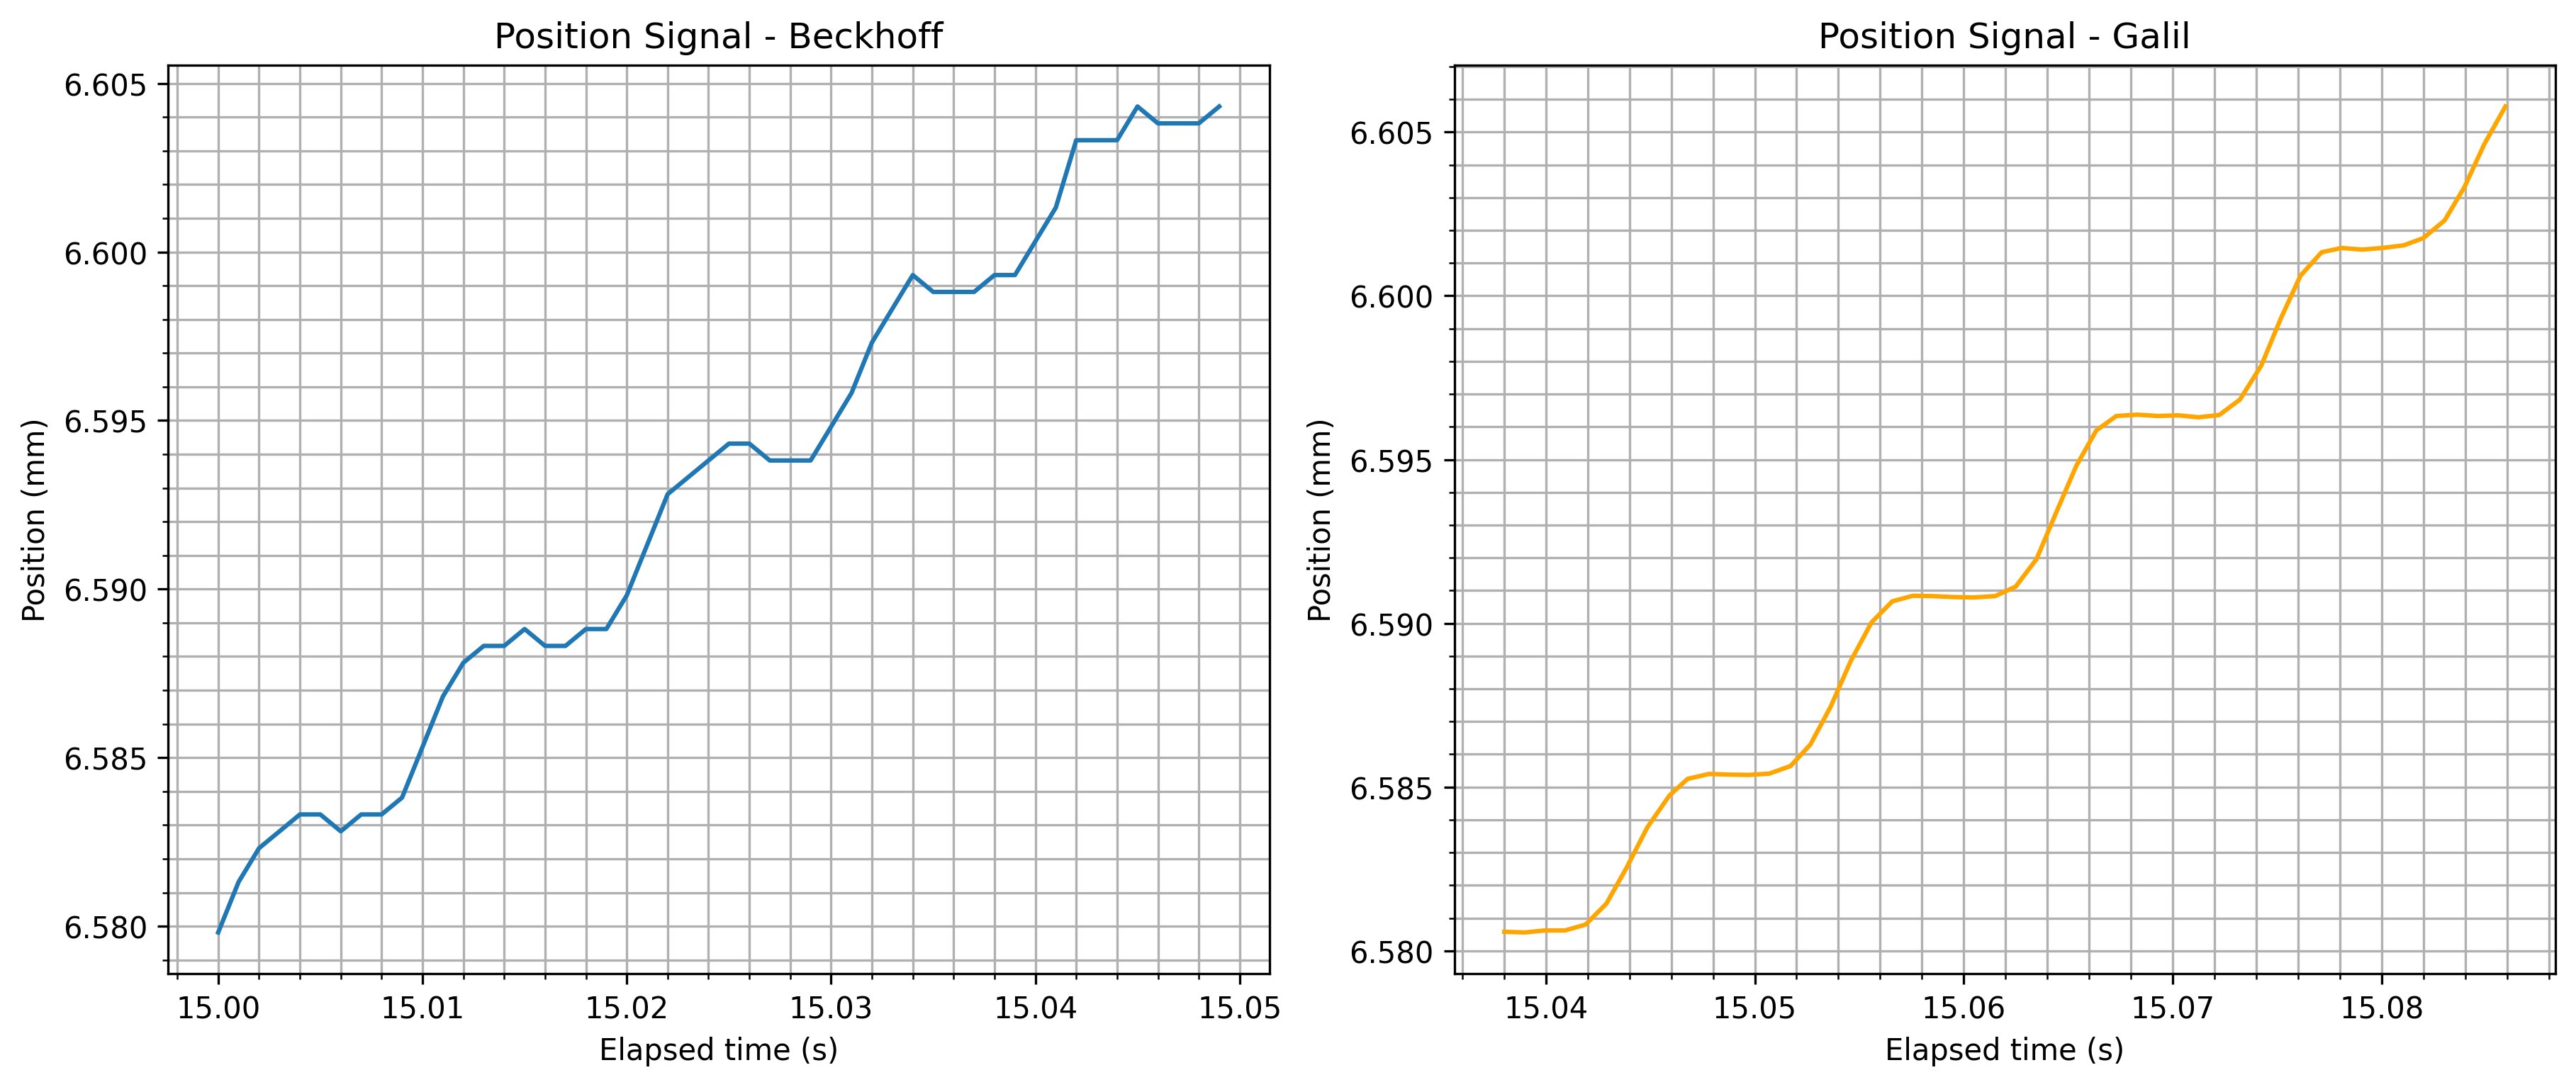

In [10]:
filename = '1_setup_og_vel500.csv' #sigle file as example
nparts=1
start=15000
end=15050
print(f'Partial movement analysis - {filename}')
b_raw_data = get_b_data(filename)
g_raw_data = get_g_data(filename)
for part in range(nparts):
    b_data = b_raw_data.iloc[start:end].reset_index() 
    g_data = g_raw_data.iloc[start+280:end+280].reset_index() #aprox. 280 samples misalignment identified to reach same Y axis
    
    b_time = b_data['Elapsed time (s)']
    b_pos = b_data['ActPos']
    g_time = g_data['Elapsed time (s)']
    g_pos = g_data['PVvalue']
  
    # plotting data

    plt.figure(figsize=(12, 5), constrained_layout=True, dpi=300)

    plt.subplot(1, 2, 1)
    plt.plot(b_time, b_pos)
    plt.xlabel('Elapsed time (s)')
    plt.ylabel('Position (mm)')
    plt.title('Position Signal - Beckhoff')
    plt.minorticks_on()
    plt.grid(True, axis='both', which='both')

    plt.subplot(1, 2, 2)
    plt.plot(g_time, g_pos, label='Galil', color='orange')
    plt.xlabel('Elapsed time (s)')
    plt.ylabel('Position (mm)')
    plt.title('Position Signal - Galil')
    plt.minorticks_on()
    plt.grid(True, axis='both', which='both')
    plt.savefig(f'{filename}-specific.png')
    plt.show()

As this behaviour expands to most lenght of movement, it's reasonable to use it to explain the non-linear deviation on difference plots. As it's a problem seen only in Beckhoff's encoder, a specific study of probable causes it might be useful. Two hypothesis are Beckhoff's low sampling frequency or encoder precision.

### Frequency Spectrum
Another interesting discrepance is in the frequency spectrum. As noted in "Position - Frequency Spectrum" plots, in all setups, beckhoff signals show a stronger presence of frequencies under 5Hz. This effect seems not to be affected by different setups such as with or without ferrite or dcm.

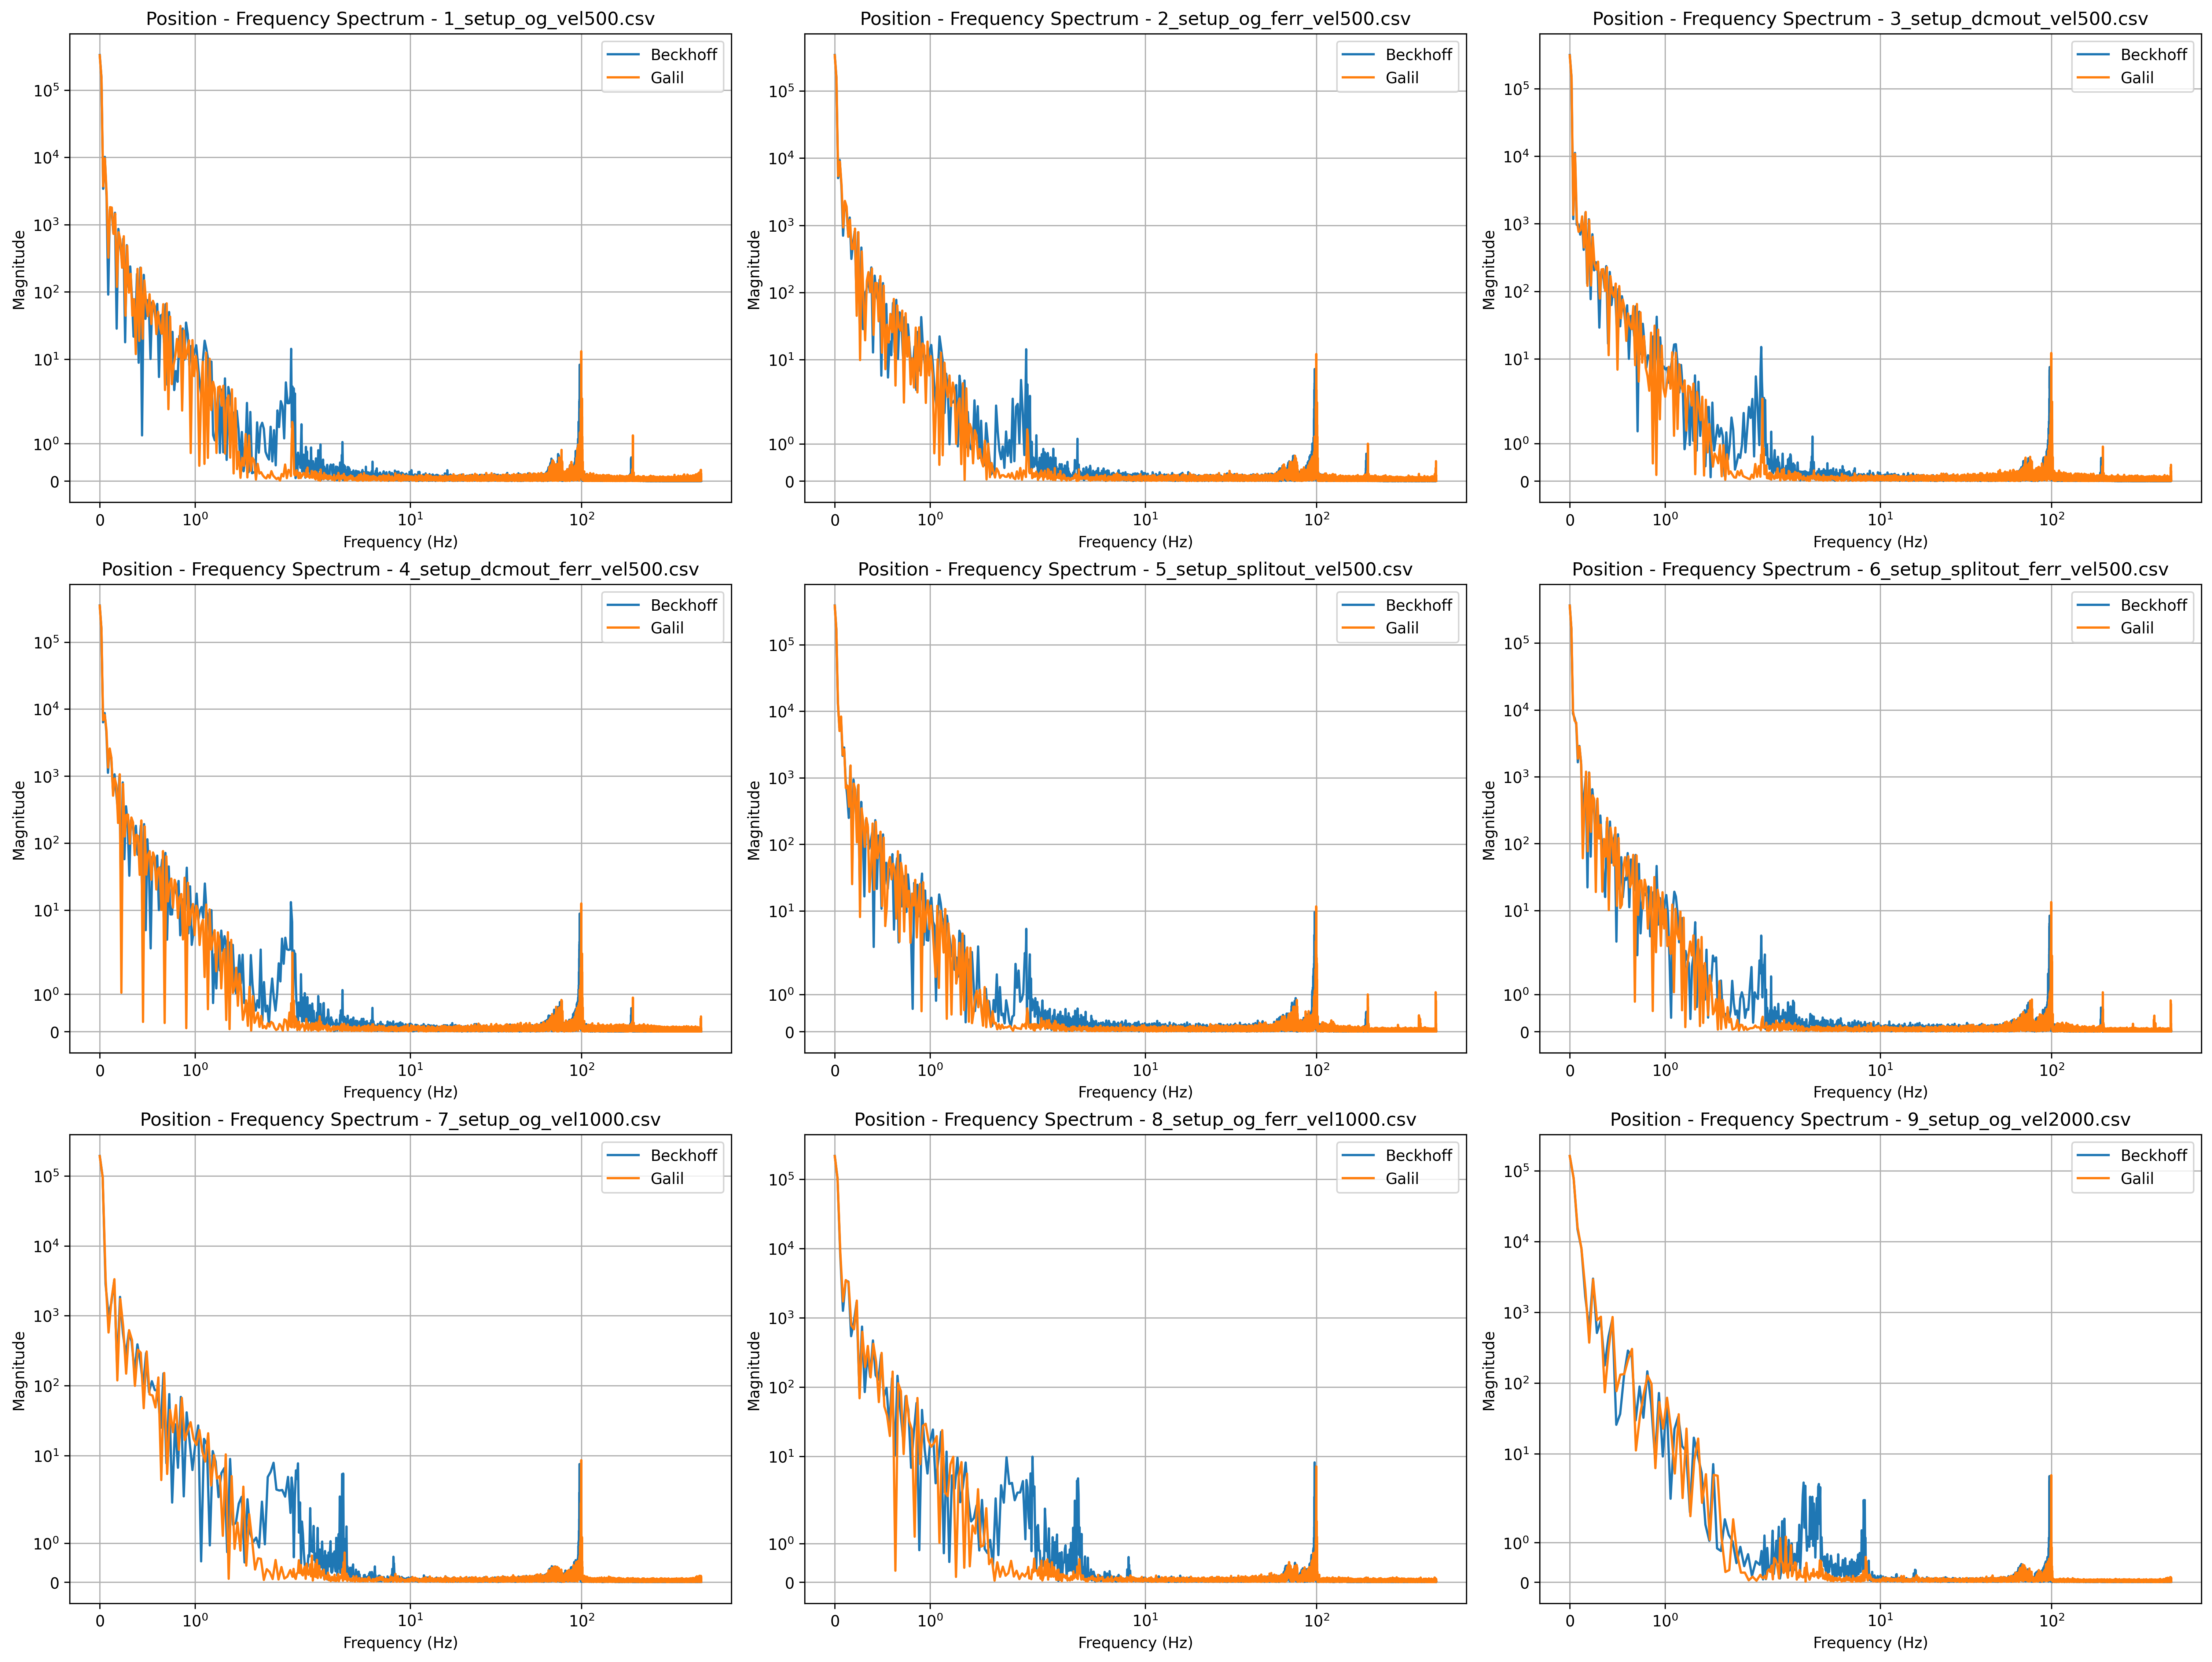

In [11]:

plt.figure(figsize=(20, 15), constrained_layout=True, dpi=300)
for i in range(len(files_beckhoff)): #picking only the first three files as example
    b_data = get_b_data(files_beckhoff[i])
    g_data = get_g_data(files_galil[i])
   
    b_time = b_data['Elapsed time (s)']
    b_pos = b_data['ActPos']
    g_time = g_data['Elapsed time (s)']
    g_pos = g_data['PVvalue']

    # positions fft
    b_nsamples = len(b_pos)
    b_yfreq = rfft(b_pos.values)
    b_xfreq = rfftfreq(b_nsamples, 0.001) #Signal Freq = 1ms

    g_nsamples = len(g_pos)
    g_yfreq = rfft(g_pos.values)
    g_xfreq = rfftfreq(g_nsamples, 0.001) #Signal Freq =~ 1ms

    plt.subplot(3,3,i+1)
    plt.plot(g_xfreq, np.abs(g_yfreq), label='Beckhoff')
    plt.plot(b_xfreq, np.abs(b_yfreq), label='Galil')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(f'Position - Frequency Spectrum - {files_beckhoff[i]}')
    plt.xscale('symlog')
    plt.yscale('symlog')
    plt.legend()
    plt.minorticks_on()
    plt.grid(True, axis='both', which='both')

plt.savefig(f'{filename}-spectrums.png')
plt.show()


As seen above, in all setups, Beckhoff shows a considerable noise in frequencies under 10Hz. Although there is no significant difference between most setups, the ones without the splitter seem to minimize this factor. As we have only two databases in that setup, more data would be necessary to confirm that hypothesis.

The source of this noise frequencies is not yet identified.